# Introduction to Testing

In [1]:
pip install -qqr requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from fastcore.all import *
from IPython.display import clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polygon import RESTClient
from utils import view_source_code, get_dollars
from datetime import datetime, timedelta, date
import math, time

In [3]:
path = Path('../data')

## Background

In Chapter 1 we created models and created actions we want to take for multiple approaches.  The question now is, how do we know if they are profitable?  How should we measure them?  How do we know if we simply got lucky, or if they are reliable?

As we mentioned in chapter 2, testing is the most important part of the process.  If done well you have a good way to determine what strategies should be implemented, and if done poorly you run the risk of implementing non-profitable strategies.  I believe you should strive to never sacrifice testing principles because effective testing is your **only** objective indication to whether you are doing something useful or not.  Without effective testing you are "flying blind".

This chapter will lay the groundwork and cover the basics of testing.  The goal of this chapter is to introduce concept and the three core things that need to be carefully considered for effective testing.

1. What data should you use for testing?
1. What metric should you use for testing?
1. What test should you use?

In this chapter we are going to walk through the concepts to see each step and understand the importance.  In the next chapter we are going apply our knowledge to build a better structured solution and framework that we can use through the remainder of the book.

## What data should you use for testing?

The first question we have to ask is what data to we use for testing?  Ideally we have 3 subsets of our data (training, validation, and test).  Let's go through what they are used for and why they are important.

### Training Set

The training set is unique because it has no restrictions on what we can do with it.  We can look at any piece of data in it.  We can normalize data using values in the training set.  We can train machine learning models on the training set.  This is often the largest subset of our data.

This training set is pretty explanatory - we use this for understanding our data and developing our model.  

We can load it in using the same method as we did in chapter 1.

In [4]:
raw = pd.read_csv(path/'eod-quotemedia.csv',parse_dates=['date'])
df = raw.pivot(index='date', columns='ticker',values='adj_close')
train = df.loc[:pd.Timestamp('2017-1-1')]

### Validation Set

The goal of creating a trading strategy is to have it perform well on data that it was not developed using.  We may use data from 2015 - 2020 to create a trading strategy, but the goal is to apply it to 2021 and 2022 to make a profit.

Because we want our model to perform on *unseen* data, we create some restriction to how we use the validation set.  We do not train any models on it, and we do not use statistics or data from the validation set when creating our model.  It's data our model has never seen.  The validation set is something we can only use to see how well our strategy or model performs.  

The entire purpose of the validation set is to give us unseen data to evaluate our approaches on.  By having this separate validation set we can more accurately determine what works and what doesn't.

We can get our validation set using the same method as we did in chapter 1.

In [5]:
valid = df.loc[pd.Timestamp('2017-1-1'):]

### Test Set


The Test set is very similar to the validation set, but it takes things a step further.  It has further restrictions in that is is the final model step before deployment.  The main difference is how often you can use it.  For the validation set, you can test anything on the validation set as many times as you want.  For the test set you only get to look at the test set once for your particular approach.

For example, you may try 300 different approaches and parameter changes to your strategy to see what works best.  You can check the profitability on each of them using the validation set.  Then once you have chosen a strategy, you do a final check to ensure it also performs on the test set.  Once you have done that you need a new test set or your project is over.

The reason this is important is that you want to ensure that you didn't get lucky and find a configuration out of your 300 attempts that just happens to work on the validation set but doesn't work elsewhere.  If you try enough combinations eventually you will find something that works, but the test set gives you confidence that your model works because it's a good strategy and not that you just tried enough things to find something that works on coincidence.


:::{note} Many people re-use or have more lax rules on the test set.  Many people do not use one at all.  In this text I am laying out the ideal state I believe we should strive for.  If you choose to loosen these restrictions on the test set or do without one, I would strongly encourage you to think hard about it.


To get our test set, we could have split our initial data into 3.  Because we are a bit concerned about survivorship bias, let's pull a new test set that uses recent data to and test how these strategies would perform over the last year and a half.

We need to get adjusted close price.  There are a variety of services that have APIs to pull from, I have picked polgygon to use here because it's free for what we need.

:::{note} We are using a free api key and putting the key in this notebook in an effort to show everthing to the reader, but best practice would be to read the api key from an environment variable.  From the polygon docs it will by default pull the api key from the `POLYGON_API_KEY` environment variable, then you would initiate the client with so that no credentials are exposed.
`client = RESTClient()`

In [6]:
polygon_free_api_key = 'wUv2tpS05klv9ebAQKyLD610FBWllpan'
client = RESTClient(polygon_free_api_key)

In [7]:
if not (path/'polytest_eod-quotemedia.csv').exists():
    dfs = L()
    errors = L()
    for ticker in valid:
        try:
            aggs = client.get_aggs(ticker, 1, "day", "2021-01-01", "2022-05-31",adjusted=True)
            close = {ticker:[o.close for o in aggs]}
            
            # Convert millisecond time stamp to date
            date = L(o.timestamp/1e3 for o in aggs).map(datetime.fromtimestamp)
            dfs.append(pd.DataFrame(close,index=date))
        except:
            errors.append(aggs)
            print(f"FAILURE: {ticker}")
        
        # Free api gives 5 API calls / minute - so we need to pace our api calls!
        time.sleep(60/5)
    df_test = pd.concat(dfs,axis=1)
    df_test.to_csv(path/'polytest_eod-quotemedia.csv')

df_test = pd.read_csv(path/'polytest_eod-quotemedia.csv',index_col=0,parse_dates=True)

In [8]:
df_test.iloc[:5,:5]

,A,AAL,AAP,AAPL,ABBV
2021-01-04,118.64,15.13,157.34,129.41,105.41
2021-01-05,119.61,15.43,157.17,131.01,106.50
2021-01-06,122.89,15.52,166.25,126.60,105.58
2021-01-07,126.16,15.38,167.67,130.92,106.71
2021-01-08,127.06,15.13,170.06,132.05,107.27


## What metric should you use for testing?

Now that we understand what data we will use for testing, let's start figuring out how well our first model from chapter 1 performs.

The next step is to figure out an appropriate metric.  There are a variety of ways to measure this and we will walk through a few first steps in this section

### Dollars

Let's take our first model from chapter 1 and measure how well it does in terms of dollars.  After all dollars is what we want to make, so it seems like a reasonable starting point.

In [9]:
from SimpleTimeSeries import get_momentum_actions

In [10]:
view_source_code(get_momentum_actions)

In [11]:
valid_mom = get_momentum_actions(valid,28,0.08).reset_index()

In [12]:
transactions = pd.melt(valid_mom,id_vars='date',value_name='action')
transactions = transactions.loc[transactions.action != '']
transactions.columns = ['open_date'] + L(*transactions.columns[1:])

In [13]:
transactions.head()

,open_date,ticker,action
0,2017-02-14,A,Buy
2,2017-02-16,A,Buy
11,2017-03-02,A,Buy
13,2017-03-04,A,Buy
14,2017-03-07,A,Buy


Now we have a dataframe with all the positions we are going to take and when to take them.  But we are missing one crucial piece!  When should we close those positions.  We cannot make money by simplying buying a stock (ignoring dividends for now) - the profit comes when we actually close the position and sell the stock.  Let's close the position 28 days after opening.

In [14]:
transactions['close_date'] = transactions.open_date + timedelta(28)
transactions = transactions.loc[transactions.open_date < (transactions.open_date.max() - timedelta(28))]

In [15]:
transactions.head()

,open_date,ticker,action,close_date
0,2017-02-14,A,Buy,2017-03-14
2,2017-02-16,A,Buy,2017-03-16
11,2017-03-02,A,Buy,2017-03-30
13,2017-03-04,A,Buy,2017-04-01
14,2017-03-07,A,Buy,2017-04-04


Next we need to get the stock price on the date of our initial action when we open to position, as well as when we close our position.  Let's start with the price on the day we open.

In [16]:
df_valid_long = valid.melt(var_name='ticker',value_name='adj_close',ignore_index=False).reset_index()
df_valid_long.columns = ['dte','ticker','adj_close']

In [17]:
transactions['open_date'] = pd.to_datetime(transactions.open_date)
df_valid_long['dte']      = pd.to_datetime(df_valid_long.dte)
pd.merge(left=transactions,left_on=['open_date','ticker'],
         right=df_valid_long,right_on=['dte','ticker'],
         how='left').head(10)

,open_date,ticker,action,close_date,dte,adj_close
0,2017-02-14,A,Buy,2017-03-14,2017-02-14,49.703267
1,2017-02-16,A,Buy,2017-03-16,2017-02-16,50.147135
2,2017-03-02,A,Buy,2017-03-30,2017-03-02,50.679775
3,2017-03-04,A,Buy,2017-04-01,NaT,NaN
4,2017-03-07,A,Buy,2017-04-04,2017-03-07,50.512092
5,2017-03-11,A,Buy,2017-04-08,NaT,NaN
6,2017-03-16,A,Buy,2017-04-13,2017-03-16,52.327016
7,2017-03-18,A,Buy,2017-04-15,NaT,NaN
8,2017-05-24,A,Buy,2017-06-21,2017-05-24,58.568656
9,2017-05-25,A,Buy,2017-06-22,2017-05-25,58.637875


Uh oh - We have a join that isn't working correctly and get `NaT` and `NaN`!  We created our model assuming that we could make transactions any day we want, but the stock market is not open every day.  There are limitations to when we can trade openly in the stock market we need to start accounting for.  

When we trade using the adjusted close price we added a day because we wouldn't be able to actually place the trade until the following day.  If that day ended up being a Saturday in reality we would have to wait until Monday to place that trade (assuming that monday isn't a holiday).  

Let's fix that by getting the next available trading day for each date.  Because we know this same thing applies to our `close_date`, we will fix it there as well.

In [18]:
unique_dates = L(o.date() for o in valid.index)
unique_dates.sort()

In [19]:
def get_next_trading_day(dte,unique_dates):
    return unique_dates.filter(lambda x: pd.Timestamp(x) >= pd.Timestamp(dte))[0]

In [20]:
f = bind(get_next_trading_day,unique_dates=unique_dates)
transactions['open_date'] = transactions.open_date.apply(f)
transactions['close_date'] = transactions.close_date.apply(f)

In [21]:
transactions['open_date'] = pd.to_datetime(transactions.open_date)
transactions['close_date'] = pd.to_datetime(transactions.close_date)


Now we can merge in the price correctly!

In [22]:
transactions = pd.merge(left=transactions,left_on=['open_date','ticker'],
                         right=df_valid_long,right_on=['dte','ticker'],
                          how='left')
transactions = pd.merge(left=transactions,left_on=['close_date','ticker'],
                         right=df_valid_long,right_on=['dte','ticker'],
                          how='left',
                          suffixes=('_atOpen','_atClose'))

In [23]:
transactions.head(3)

,open_date,ticker,action,close_date,dte_atOpen,adj_close_atOpen,dte_atClose,adj_close_atClose
0,2017-02-14,A,Buy,2017-03-14,2017-02-14,49.703267,2017-03-14,51.498464
1,2017-02-16,A,Buy,2017-03-16,2017-02-16,50.147135,2017-03-16,52.327016
2,2017-03-02,A,Buy,2017-03-30,2017-03-02,50.679775,2017-03-30,52.593336


In [24]:
def f_committed(x):
    if x.action in ('Buy','Short'): return x.adj_close_atOpen  
    else: return 0
transactions['committed'] = transactions.apply(f_committed,axis=1)

def f_revenue(x):
    if x.action=="Buy": return x.adj_close_atClose
    else:               return x.adj_close_atOpen
transactions['revenue'] = transactions.apply(f_revenue,axis=1)

def f_cost(x):
    if x.action == 'Buy': return x.adj_close_atOpen  
    else:                 return x.adj_close_atClose
transactions['cost'] = transactions.apply(f_cost,axis=1)

transactions['profit'] = transactions.revenue - transactions.cost


In [25]:
transactions['committed'] = transactions.apply(f_committed,axis=1)
transactions['revenue'] = transactions.apply(f_revenue,axis=1)
transactions['cost'] = transactions.apply(f_cost,axis=1)
transactions['profit'] = transactions.revenue - transactions.cost


In [26]:
get_dollars(transactions[transactions.action=='Buy'].profit.sum()), \
get_dollars(transactions[transactions.action=='Short'].profit.sum()), \
get_dollars(transactions.profit.sum())

('$7457.36', '$190.98', '$7648.35')

Great!  So according to our validation set we made a good chunk of profit (pre-tax).  We could buy/short in higher volumes (ie Buy = 10x buys, Short = 10x shorts) to make this profit larger.

However, this really isn't enough information to determine whether that is a good idea of feasible.  I would love to loan someone 100 dollars if they would give me one-thousand dollars back a week later.  I would hate to loan someone 1,000,000 dollars on the promise that they would pay me 1,000,900 dollars back in 20 years.  The reward just wouldn't be worth the risk, and I can use that money better in a 20-year span than that.

Let's see if we can come up with a better metric that accounts for this.

### Percent Return

Instead of measuring raw dollars, lets consider how much money (capital) we needed in order to make that 90 dollars profit.  To do this we need to keep track of our money more carefully than just looking at how much we made at the end.  Let's track out financials by day instead of by transaction o calculate this.

:::{note} I am using "committed" to be the amount we have invested + the amount leveraged.  For now, let's assume that we won't take out debt and borrow stocks (shorting) if we do not have the capital to cover the initial price we borrowed at

In [27]:
df = pd.DataFrame()
for cols in [['open_date','committed'],['close_date','profit'],['close_date','revenue'],['open_date','cost']]:
    _tmp = transactions[cols].groupby(cols[0]).sum()
    df = pd.merge(df,_tmp,how='outer',left_index=True,right_index=True)
df.fillna(0,inplace=True)
df.sort_index(inplace=True)
df.sample(8)

,committed,profit,revenue,cost
2017-06-26,0.000000,138.832474,18019.732453,0.000000
2017-04-27,5968.479019,46.974470,3877.153527,5961.515502
2017-06-12,0.000000,131.413261,13512.259743,0.000000
2017-04-11,5014.274493,-125.564332,10907.909502,5023.897841
2017-04-04,4267.815952,-15.053707,12248.680733,4286.988686
2017-06-28,0.000000,27.121677,18392.604923,0.000000
2017-05-17,13857.934536,147.911722,5492.438827,13896.342477
2017-05-02,12175.535293,70.927741,4357.916427,12119.244305


Now we can easily look at when we had the most committed.  We are subtracting revenue because once we get money back we can reinvest rather than using new money.

In [28]:
capital_needed = (df.committed.cumsum()-df.revenue.cumsum()).max()
get_dollars(capital_needed)

'$274744.63'

And of course our profit is still the same as we had before because we are just aggregating the data differently.

:::{note} This is the first time we are using the [fastcore's testing framework](https://fastcore.fast.ai/test.html).  It has several handy and easy to use testing functions, such as testing if 2 numbers are arbitrarily close (useful for floats).

In [29]:
test_close(transactions.profit.sum(),df.profit.sum())
get_dollars(df.profit.sum())

'$7648.35'

Now that we see our capital needed and our profit, let's calculate a percent return

In [30]:
f"Percent Return: {(df.profit.sum() / capital_needed) * 100:.2f}%"

'Percent Return: 2.78%'

### Log Return

More commonly rather than using the percent return we want to use the log return.  There are a lot of reasons they are advantageous to use that will be covered throughout the book as they are significant to what we are doing.  For now we will cover one that is immediately useful to us.

**Symmetry / Additive**
+ Percent Return
    - Invest 100 dollars
    - Get 50% Return on investment 1 and reinvest
    - Get -50% Return on investment 2
    - End with **75** dollars
+ Log Return
    - Invest 100 dollars
    - Get 50% Return on investment 1 and reinvest
    - Get -50% Return on investment 2
    - End with **100** dollars

This property where a positive return + an equal-sized negative return = no return makes it much easier to look at returns and figure out if you are winning or losing.  Just add up all your log returns to get your overall log return.  You have to be much more careful with percent returns.


In [48]:
pt = capital_needed + df.profit.sum()
pt_1 = capital_needed
log_return = math.log(pt/pt_1)
f"{math.log(pt/pt_1)*100:.2f}%"

'2.75%'

As we calculate the log return we see we get a very similar value to our percent return, but it's not exactly the same.  The advantage of using the log return however is we can accurate get an estimated annualized return.

This is great because we can easily have everything thought of as an annualized return so that we have a common time frame to compare investment strategies more easily.

In [49]:
time_period = (df.index.max().date() - df.index.min().date()).days

In [50]:
f"{(log_return/time_period * 365)*100:.2f}%"

'7.37%'

Now we can just convert to normal return to compare very simply to S&P 500 annual return

In [51]:
f"{(np.exp(log_return/time_period * 365)-1)*100:.2f}%"

'7.65%'

Go ahead an look up S&P 500 annual returns for each year online and compare.  How does this fare?

## Statistical Tests

### Motivation

If you bought fifty 1.50 dollar lottery tickets and won 10 million dollars in the lottery, what could you say about your chances to win?  Well let's calculate our rate of return.

$$\frac{10,000,000 - 75}{75} = 133,332.33$$

So based on our calculations, the rate of return for playing the lottery is fantastic.  But we know that this doesn't really reflect reality or mean that it's a good safe investment strategy.  We know that you would've just gotten lucky.

So how do we determine if our trading strategy is a good strategy, or we just got lucky this time?  This is where statistical testing comes in.

I will cover the basics that I think are key, but if you'd like more detail and practice I reading [Statistics: Unlocking the Power of Data](https://www.lock5stat.com/).  Unlike most statistics book it is extremely applied and focused on data, with lots of real world examples.

### Bootstrapping

#### Background

Statistical testing can be done be done using 2 general approaches.  The first is the classical approach with is the most widely known.  The second is through bootstrapping.  This chapter will focus on bootstrapping because in my opinion it is the first that should be learned. 

Bootstrapping is less commonly accepted but is the more powerful and flexible of the two.  In bootstrapping you create a sampling distribution by by taking many samples and performing an experiment.  In traditional testing you use clever algebra to approximate a sampling distribution.  With todays computer you can almost always use bootstrapping and I believe it it the more powerful and flexible approach.

With Bootstrapping you start with just the data and make no other assumptions about the data.  With classical methods you start with the data and some assumptions about the data in order to arrive at an answer.  If you make incorrect assumptions then you get an incorrect answer - and determining which assumptions are safe to make is not always trivial.

The idea of bootstrapping and the power of it has also been spoken of by many of the statistical greats for almost 100 years, much longer than it was feasible to do, [as pointed out in this article](https://www.lock5stat.com/Lock5Overview.pdf).

For example, that article points out that in 1936 Sir R.A. Fisher spoke about using this bootstrapping approach:

> Actually, the statistician does not carry out this very simple and very tedious process, but his conclusions have no justification beyond the fact that they agree with those which could have been arrived at by this elementary method.

However while these methods were tedious in 1936, they are trivial thanks to modern computers.  We no longer have to do clever algebraic tricks to approximate a sampling distribution - we can just create a sampling distribution.

That said, I do believe it's good and useful to have the ability to use both approaches.  Luckily, traditional testing is just algebraic tricks to approximate what we will do here and so it will not be too hard to pick that up on top of bootstrapping.  In this section we will focus on Bootstrapping because in my opinion it is the one that should be learned first.

Please see our chapter on "Bootstrapping vs Classical Statistics" for more detail and understanding on both methods and information on how traditional statistics are really just estimations of a sampling distribution for when you do not have enough compute to actually create the sampling distributions. 

#### Bootstrap Test

With any type of testing we need to understand what we are testing.  We are going to have 2 competing hypothesis.  The first in the **null hypothesis**.  The null hypothesis is what we assume to be true, until we have evidence otherwise.  

In the context of trading strategies we might make the hypothesis that our strategy will yield returns equal to that of randomly picking stocks.  If we randomly pick stocks we know that it will roughly match the market so that seems like a reasonable thing to want to beat.  The null hypothesis is important because our goal of testing is to determine whether we have sufficient evident to reject that null hypothesis.

The alternate hypothesis is what we are testing for.  For example, if the null hypothesis is that our strategy will yield returns equal that that of investing in random stocks the alternate hypothesis could be that our strategy will yield returns greater than if we were to invest in random stocks.

First we need a few functions:
+ A function to run our null hypothesis model (random)
+ A function to run the model we created and have been exploring throughout the chapter
+ A function to measure the statistic of each run (log return of the models)

We will look in the next chapter on better ways to organize this code, how to speed it up and run in parallel, and the like, but the focus here in general concepts.  We will use our understanding of these concepts in the next chapter to structure this better.

##### Null Hypothesis Model

Let's design a Null Hypothesis.  There are many Null Hypothesis' you can choose, and one of the beauty of bootstrapping is that you can think about it very intuitively and design the experiment exactly how you want easier.

In [36]:
def run_random(input_df,buy_chance,short_chance,hold_time):
    input_df_long = input_df.melt(var_name='ticker',value_name='adj_close',ignore_index=False).reset_index()
    
    # Buy/Short stocks using random chance, probabilities to be passed as arguements
    buys = input_df_long.loc[np.random.rand(input_df_long.shape[0])<buy_chance].copy()
    shorts = input_df_long.loc[np.random.rand(input_df_long.shape[0])<short_chance].copy()

    # Concatenate into 1 dataframe
    buys['action'] = 'Buy'
    shorts['action'] = 'Short'
    transactions = pd.concat([buys[['date','ticker','action']],
                            shorts[['date','ticker','action']]])
    
    # Close the positions
    transactions['close_date'] = transactions.date + timedelta(hold_time)
    transactions = transactions.loc[transactions.date < (transactions.date.max() - timedelta(hold_time))]
    
    # Adjust dates for when market is open
    f = bind(get_next_trading_day,unique_dates=L(*input_df.index.date))
    transactions['date'] = pd.to_datetime(transactions.date.apply(f))
    transactions['close_date'] = pd.to_datetime(transactions.close_date.apply(f))
    return transactions

##### Alternate Hypothesis Model

We also need a model that we are hoping performs well that we are trying to evaluate whether it is better than our random null hypothesis or not.  For this, we will just use the model we have been working on throughout the chapter.

In [37]:
def run_model(input_df,n_periods,threshold,hold_time):
    valid_mom = get_momentum_actions(input_df,n_periods,threshold).reset_index()
    transactions = pd.melt(valid_mom,id_vars='date',value_name='action')
    transactions = transactions.loc[transactions.action != '']
    transactions['close_date'] = transactions.date + timedelta(hold_time)
    transactions = transactions.loc[transactions.date < (transactions.date.max() - timedelta(hold_time))]

    f = bind(get_next_trading_day,unique_dates=L(*input_df.index.date))
    transactions['date'] = pd.to_datetime(transactions.date.apply(f))
    transactions['close_date'] = pd.to_datetime(transactions.close_date.apply(f))
    return transactions

##### Calculate Returns

Next, we need a function that can take our 2 different model outputs (for null and alternate hypothesis) and calculate the statistic we care about (log return).  We do this by drawing on our work earlier in the chapter.

In [38]:
def calculate_returns(transactions_df,input_df):
    input_df_long = input_df.melt(var_name='ticker',value_name='adj_close',ignore_index=False).reset_index()
    # Merge in stock prices
    transactions = pd.merge(left=transactions_df,left_on=['date','ticker'],
                             right=input_df_long,right_on=['date','ticker'],
                              how='left')

    transactions = pd.merge(left=transactions,left_on=['close_date','ticker'],
                             right=input_df_long,right_on=['date','ticker'],
                              how='left',
                              suffixes=('_atOpen','_atClose'))
    transactions = transactions[['ticker','action','date_atOpen','adj_close_atOpen','date_atClose','adj_close_atClose']]

    # Calculate profit for each transaction
    transactions['committed'] = transactions.apply(f_committed,axis=1)
    transactions['revenue'] = transactions.apply(f_revenue,axis=1)
    transactions['cost'] = transactions.apply(f_cost,axis=1)
    transactions['profit'] = transactions.revenue - transactions.cost

    # Create Daily dataframe
    df_daily = pd.DataFrame()
    for cols in [['date_atOpen','committed'],['date_atClose','profit'],
                 ['date_atClose','revenue'],['date_atOpen','cost']]:
        _tmp = transactions[cols].groupby(cols[0]).sum()
        df_daily = pd.merge(df_daily,_tmp,how='outer',left_index=True,right_index=True)
    df_daily.fillna(0,inplace=True)
    df_daily.sort_index(inplace=True)
    
    # Calculate Log Return
    pt_1 = (df_daily.committed.cumsum()-df_daily.revenue.cumsum()).max()
    pt = pt_1 + df_daily.profit.sum()
    return math.log(pt/pt_1)

calculate_returns(run_model(valid,28,0.08,28),valid),\
calculate_returns(run_random(valid,.1,0.05,28),valid),

(0.0274575941649795, 0.031296928347923664)

##### Statistical Test

Now that we have the setup let's start our test.  First for our random model we need to give it a buy and short chance probability.  Let's assume roughly even volume of trades to keep things simple and get the probabilities from our model.  In this way our random model trades at the same volume and frequency, just using random selection instead of momentum selection.

In [39]:
df_long = valid.melt(var_name='ticker',value_name='adj_close',ignore_index=False).reset_index()
t = run_model(valid,28,0.08,28)
buy_chance = sum(t.action=='Buy')/len(df_long)
short_chance = sum(t.action=='Short')/len(df_long)
print(f"Model buy percentage={buy_chance}")
print(f"Model buy percentage={short_chance}")

Model buy percentage=0.08691717171717171
Model buy percentage=0.04311919191919192


Great - Let's bind these to a function.  This is a functional programming principle that is extremely common in functional languages in the form of currying.  Python isn't quite as convenient so we use [fastcore's bind](https://fastcore.fast.ai/basics.html#bind) for this (which is like the more common [functool partial](https://docs.python.org/3/library/functools.html#functools.partial), with a few added conveniences).

This allows us to pass our model functions as parameters which will be convenient when we want to try different parameters.  We could also just have all the parameters for either function as arguments in the main `run_bootstrap_test` function, but that can get rather clunky and confusing.

In [40]:
model_h0 = bind(run_random,buy_chance=buy_chance,short_chance=short_chance,hold_time=28)

Now we get to the meat of bootstrapping.  Really all we are doing is tacking different samples and running both models many times on different samples.  In classical statistics the normal distribution or some other distribution is assumed so that we can approximate a sampling distribution.  In bootstrapping we just create the sampling distribution directly.

In [41]:
def run_bootstrap_test(input_df,model_h0,runs,sample_size):
    r_h0 = L()
    input_df_long = input_df.melt(var_name='ticker',value_name='adj_close',ignore_index=False).reset_index()
    unique_tickers = input_df_long.ticker.unique()
    
    for i in range(runs):
        ticker_sample = np.random.choice(unique_tickers,sample_size) 
        valid_sample = input_df[ticker_sample]

        t_h0 = model_h0(valid_sample)

        r_h0.append(calculate_returns(t_h0,valid))
    return r_h0

##### Plot Experiment

It's always helpful to visualize whatever you can.  Visualizing the data will help you build intuition, generate additional ideas, spot outliers, and identify possible errors in your code.  Let's start with plotting our initial parameters we are using.

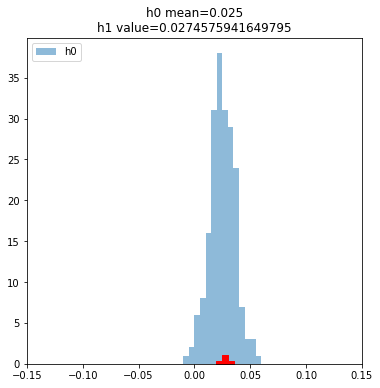

In [42]:
fig,ax = plt.subplots(figsize=(6,6))

model_h0 = bind(run_random,buy_chance=buy_chance,short_chance=short_chance,hold_time=28)
model_h1 = bind(run_model,n_periods=28,threshold=0.08,hold_time=28)
    
runs, ss = 200,100
h0 = run_bootstrap_test(valid,model_h0,runs=runs,sample_size=ss)
ax.set_xlim(-.15,.15)

ax.hist(h0,alpha=0.5,bins=60,label = 'h0',range=(-.15,.15))
x = calculate_returns(model_h1(valid),valid)
ax.scatter(x=x,y=0,marker="P",color='red',s=300)

title_r1 = f"h0 mean={np.array(h0).mean():.4f}\n"
title_r2 = f"h1 value={x:.4f}"

ax.set_title(title_r1 + title_r2)
ax.legend(loc ='upper left') 

The blue histogram is the distribution of our random sampling.  The Red is our models return.  Visually the red point seems perfectly in line with the random distribution, but let's be a bit more scientific about it.  Let's calculate the p-value, and talk about what that means.

In [43]:
p_value = (np.array(h0)>x).sum()/runs
print(p_value)

0.405


The p-value tells us the percentage of samples from our randomized null hypothesis trials that are more extreme than our model's return.  Roughly 40% of the time we get a more unusual result just using our random selection - which tells us that from this look our model is pretty indistinguishable from our random model.

Said in statistical jargon, we failed to reject the null hypothesis.

Let's try something else

##### What if we hold for less time?

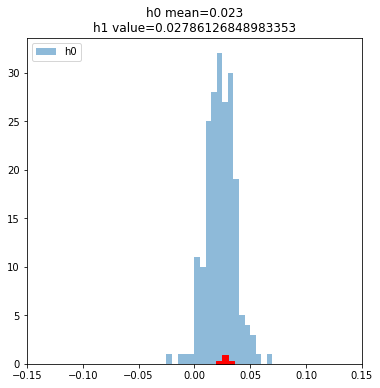

In [44]:
fig,ax = plt.subplots(figsize=(6,6))

model_h0 = bind(run_random,buy_chance=buy_chance,short_chance=short_chance,hold_time=14)
model_h1 = bind(run_model,n_periods=28,threshold=0.08,hold_time=14)
    
runs, ss = 200,100
h0 = run_bootstrap_test(valid,model_h0,runs=runs,sample_size=ss)
ax.set_xlim(-.15,.15)

ax.hist(h0,alpha=0.5,bins=60,label = 'h0',range=(-.15,.15))
x = calculate_returns(model_h1(valid),valid)
ax.scatter(x=x,y=0,marker="P",color='red',s=300)

title_r1 = f"h0 mean={np.array(h0).mean():.4f}\n"
title_r2 = f"h1 value={x:.4f}"

ax.set_title(title_r1 + title_r2)
ax.legend(loc ='upper left') 

In [45]:
p_value = (np.array(h0)>x).sum()/runs
print(p_value)

0.395


This isn't any better.  But that's ok, because that's how the process works.  Most of your experiments will fail, and this was only our first model.  Let's try one more idea.

##### What if we use a larger period size for momentum?

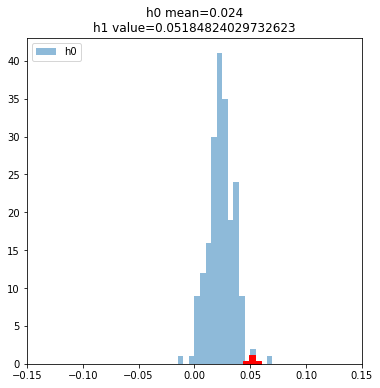

In [46]:
fig,ax = plt.subplots(figsize=(6,6))

model_h0 = bind(run_random,buy_chance=buy_chance,short_chance=short_chance,hold_time=28)
model_h1 = bind(run_model,n_periods=56,threshold=0.08,hold_time=28)
    
runs, ss = 200,100
h0 = run_bootstrap_test(valid,model_h0,runs=runs,sample_size=ss)
ax.set_xlim(-.15,.15)

ax.hist(h0,alpha=0.5,bins=60,label = 'h0',range=(-.15,.15))
x = calculate_returns(model_h1(valid),valid)
ax.scatter(x=x,y=0,marker="P",color='red',s=300)

title_r1 = f"h0 mean={np.array(h0).mean():.4f}\n"
title_r2 = f"h1 value={x:.4f}"

ax.set_title(title_r1 + title_r2)
ax.legend(loc ='upper left') 

In [47]:
p_value = (np.array(h0)>x).sum()/runs
print(p_value)

0.005


Now we're talking!  A very small percentage of the values from our random model are more extreme than the one we got with our model.

But now this invites a new question - how small does the p-value need to be to reject the null hypothesis?  0.05 is the most common and many people use this by default, but **what your p-value threshold is is a design choice that has real implications on your testing**.  This is something to carefully consider.  Remember, testing is our only objective signal for whether we are doing something right or not so it deserves the most care and consideration.

Let's consider the extremes so that we can easily thing about the trade-off.

**What if the p-value threshold we pick is large (ie 0.5)?***

With a p-value threshold of 0.5, we accept anything where less than 50% of the values from the randomized null hypothesis tests are more extreme.  The risk of this means that we will have a lot of false positives.  Said another way, LOTS of stuff will pass our test many of them just because of luck.  

Said simply, we will think a lot of bad ideas are good ideas.  


**What if the p-value threshold we pick is small (ie 0.000001)?***

With a p-value this small almost nothing will pass the test, but if it does we can be pretty confident in it!  The problem with this is many good ideas will fail the test just because of bad luck.

Said simply, we will have a lot of good ideas that we won't realize are good ideas.  These are missed opportunities.


**The Tradeoff**

So really the P value is a trade-off.  A lower P value is more cautious and safe but you will miss out on some opportunities.  A high P value is riskier and more of your approaches will turn out to fail.

More details will come throughout the book on this, but it is important to understand that this is a tradeoff.  For a more detailed guide to testing read the hypothesis testing material in [Statistics: Unlocking the Power of Data](https://www.lock5stat.com/)